In [ ]:
#| default_exp preprocess

In [ ]:
#| hide
from nbdev.showdoc import *

# preprocess
> This module will contain the functions used to preprocess the data to be used in the training process and it will contain the preprocessing done to successfully batch data

In [ ]:
#| export
from pathlib import Path
import librosa

In [ ]:
#| hide
from fastspeech.loading import *
from fastcore.foundation import L
from functools import partial
from fastspeech.visualize import show_mels

In [ ]:
#| hide
path = Path("../../data/LJSpeech-1.1/")
sr = 22050
hl = 256
cut = 10

file_paths = get_audio_files(path)
tgt_paths = L(file_paths).map(partial(replace_extension, extension='.TextGrid'))
vocab_path = Path("../../data/CMUDict/cmudict-0.7b.symbols.txt")

wavs = list(map(partial(load_audio, sr=22050), file_paths[:cut]))
phones, durations = zip(*map(partial(get_phones_and_durations, sr=sr, hl=hl), 
                             tgt_paths[:cut]))

## phones

In [ ]:
#| export
class Vocab:
    '''This is a vocab object to used to load in a vocabulary, vectorize phonemes, and decode embeddings'''
    def __init__(self, 
                 vocab_path: str, # The path to vocabulary file containing all the words in the vocabulary
                 specials: list =[]): # The special tokens not in the vocabulary file
        pad_token = "<pad>"
        self.vocab = self._load_vocab(vocab_path) + [pad_token] + specials
        self.tok2idx = {tok: i for i, tok in enumerate(self.vocab)}
        self.pad_num = self.tok2idx[pad_token]
    
    def __getitem__(self, val: int|str): # The token string or the vectorized integer
        val_type = type(val)
        if val_type == int and val < len(self.vocab): 
            return self.vocab[val]
        elif val_type == str:
            return self.tok2idx[val]
        else:
            raise Exception(f"Used the wrong type: {val_type}")
        
    def __len__(self):
        return len(self.vocab)
        
    def _load_vocab(self, vocab_path: str): # The path to the phoneme vocab list
        lines = Path(vocab_path).open().readlines()
        return list(map(lambda x: x.strip(), lines))

In [ ]:
vocab = Vocab(vocab_path, ['spn'])
vocab[10], vocab[vocab[10]], len(vocab)

('AH1', 10, 86)

## audio

In [ ]:
#| export
def trim_audio(inp, # Input audio array
               top_db, # The threshold (in decibels) below reference to consider as silence
               n_fft, # The number of samples per analysis frame
               hl): # The number of samples between analysis frames
    audio, _  = librosa.effects.trim(y=inp, top_db=top_db, frame_length=n_fft, hop_length=hl)
    return audio

In [ ]:
#| hide
wav = wavs[0]

In [ ]:
trimmed = trim_audio(wav, top_db=30, n_fft=1024, hl=256)
len(wav) - len(trimmed)

3485

In [ ]:
#| hide
melspectrogram = partial(librosa.feature.melspectrogram, n_fft=1024, hop_length=256, n_mels=80)
mel = melspectrogram(y=wav)
trimmed_mel = melspectrogram(y=trimmed)

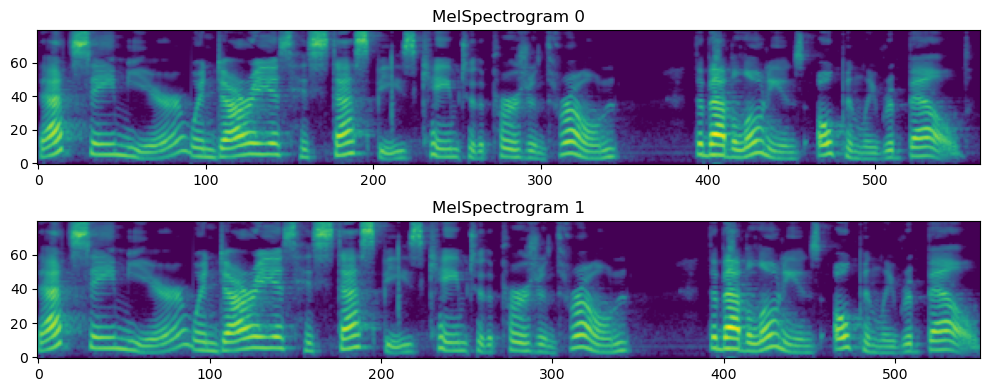

In [ ]:
show_mels([mel, trimmed_mel]);

In [ ]:
#| hide
from IPython.display import Audio, display

In [ ]:
display(Audio(wav, rate=sr))
display(Audio(trimmed, rate=sr))

## durations

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()